 # VideoLLaMA3 Inference Recipes

## Section 3: Visual Referring and Grounding

We here show the best recipes to VideoLLaMA3 for visual referring and grounding. Specifically, we provide examples to address the following two tasks:

1. `Visual Grounding`: Starting with a text prompt, the model identifies and outputs the corresponding bounding box for the mentioned object.

2. `Visual Referring`: Given a specific object with its bounding box, the model generates answers related to that particular object.


### [General] Load Model and Processor

Loading the model requires approximately 15,967 MB of VRAM at BFloat16 precision. To ensure that only one GPU is used, we restrict the CUDA visible devices to GPU 0 in this example code.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from transformers import AutoModelForCausalLM, AutoProcessor, AutoModel, AutoImageProcessor

model_path = "DAMO-NLP-SG/VideoLLaMA3-7B-Image"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

/opt/lepton/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


### Set-up
Necessary imports helper functions for box visualization.

In [2]:
from PIL import Image, ImageDraw
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import re

def extract_boxes(text):
    matches = re.findall(r'\[\[(.*?)\]\]', text)
    result = []
    
    for match in matches:
        arrays = match.split('],[')
        inner_list = []
        
        for array in arrays:
            # Remove any remaining brackets and split by comma to get individual numbers
            numbers = array.replace('[', '').replace(']', '').split(',')
            inner_list.append([int(num) for num in numbers])
        
        result.extend(inner_list)

    return result

def normalized2raw(box, h, w):
    box = [int(box[0]/1000*w), int(box[1]/1000*h), int(box[2]/1000*w), int(box[3]/1000*h)]
    return box 

def raw2normalized(box, h, w):
    box = [int(box[0]/w*1000), int(box[1]/h*1000), int(box[2]/w*1000), int(box[3]/h*1000)]
    box = [min(b, 1000) for b in box]
    return box 

def show_box(raw_box, image, process=True):
    box_image = image.copy()
    if process:
        bbox = normalized2raw(raw_box, box_image.size[1], box_image.size[0])
    else:
        bbox = raw_box
    draw = ImageDraw.Draw(box_image)
    draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], outline='red', width=2)
    
    plt.imshow(box_image)
    plt.axis('off')
    plt.show()

### 1. Visual Grounding

In this section, we will show an example for VideoLLaMA3 to achieve **Visual Grounding**, *ie*, given a sentense, output the corresponding the bounding box in the format of [[x0, y0, x1, y1]].

#### Example Image

Load image and display:

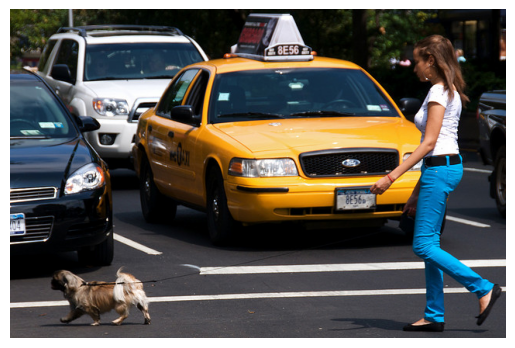

In [3]:
image_path = "visuals/cars.jpg"
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis('off')
plt.show()

Fill in the conversation here and get the corresponding response:

**[Example1]: white car**

In [4]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image", 
                "image": {"image_path": image_path}
            },
            {
                "type": "text", 
                "text": "Where is the white car? Answer in [[x0,y0,x1,y1]] format."},
        ]
    }
]


# Single-turn conversation
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=128)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(response)

<ref>the white car</ref>[[56, 42, 390, 484]]


Process the response and show the processed bounding box on the raw image:

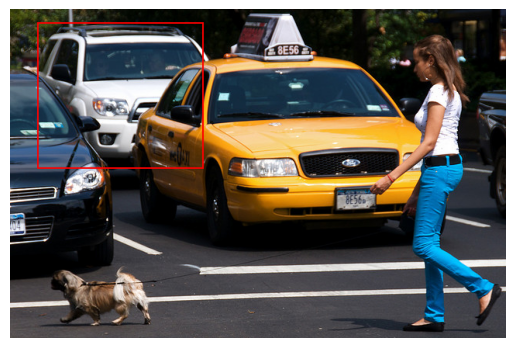

In [5]:
extracted_box = extract_boxes(response)[0]
show_box(extracted_box, image)

**[Example2]: logo of the yellow car**

<ref>the logo of the yellow car</ref>[[640, 442, 723, 485]]


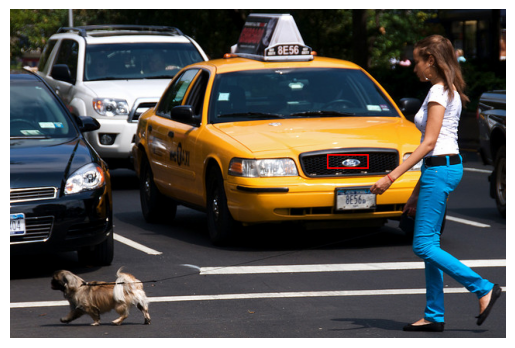

In [6]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image", 
                "image": {"image_path": image_path}
            },
            {
                "type": "text", 
                "text": "Where is the logo of the yellow car? Answer in [[x0,y0,x1,y1]] format."
            },
        ]
    }
]


# Single-turn conversation
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=128)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(response)
extracted_box = extract_boxes(response)[0]
show_box(extracted_box, image)

### 2. Visual Referring

In this section, we will show an example for VideoLLaMA3 to achieve **Visual Referring**, *ie*, given a bounding box and the question, answer question with the specific region.

#### [Example Image]

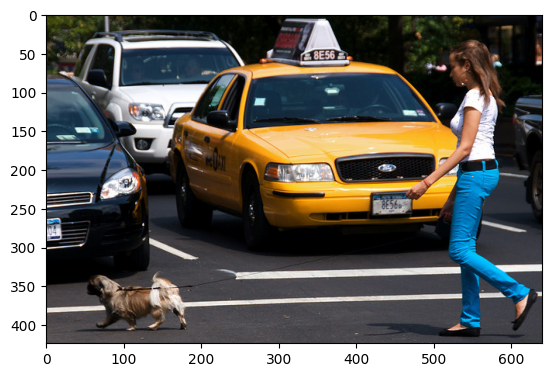

In [7]:
image_path = "visuals/cars.jpg"
image = Image.open(image_path).convert("RGB")

plt.imshow(image)
plt.axis('on')
plt.show()

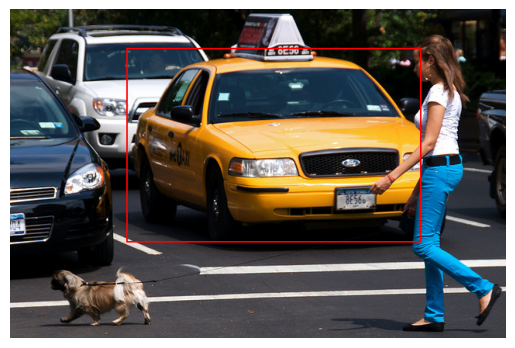

In [8]:
input_box = [150,50,530,300]
show_box(input_box, image, process=False)

Generate the conversations:

In [ ]:
normalized_box = raw2normalized(input_box, image.size[1], image.size[0])

conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image", 
                "image": {"image_path": image_path}
            },
            {
                "type": "text", 
                "text": f"What is the license plate number of {normalized_box}?"
            },
        ]
    }
]


# Single-turn conversation
inputs = processor(conversation=conversation, return_tensors="pt")
inputs = {k: v.cuda() if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
if "pixel_values" in inputs:
    inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=128)
response = processor.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print(response)

The license plate number of [234, 117, 828, 707] is '8E56'.
